# BB84 Protocol (Clean version)

In [1]:
###                                                   IMPORTING LIBRARIES
import time
import os
import numpy as np
import random
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram

from quantuminspire.credentials import get_authentication
from quantuminspire.credentials import save_account
from quantuminspire.qiskit import QI

from math import ceil
from itertools import product

In [2]:
###                                             CONNECTING TO QUANTUM INSPIRE
save_account('a2c6982402352e8e4b3bcabb8e89d7ec75d93003')
QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL,project_name='BB84 Simulation')
qi_backend = QI.get_backend('QX-34-L')

In [8]:
###                                             FUNCTIONS FOR THE BB84 PROTOCOL
def DeconstructMessage(message, n_qubits):
    
    """
    Deconstructs the message of length n into blocks of lenght n_qubits
    
    Inputs:
        - message:       nqubits-length binary array
        - n_qubits:      number of available qubits per job
    
    returns:
        - DeconMessage:  2D array with blocks of length n_qubits containing the message bits, remaining entries are set to -1
    """
    
    n_blocks = ceil(len(message)/n_qubits)
    
    DeconMessage = np.empty((n_blocks, n_qubits))
    for j in range(n_qubits):
        for i in range(n_blocks):
            try:
                DeconMessage[i,j] = message[n_qubits*i + j]
            except IndexError:
                DeconMessage[i,j] = -1
                
    return DeconMessage



def BB84CircuitBlock(AliceBasis_block, BobBasis_block, message_block):
   
    """
    Generates the Quantum Circuit for each block of n_qubit message bits
    
    Inputs:
        - AliceBasis_block: n_qubits-length array with entries 0 or 1 that indicate the basises of Alice
        - BobBasis_block:   n_qubits-length array with entries 0 or 1 that indicate the basises of Bob
        - message_block:    n_qubits-length array with entries 0 or 1 that indicate the bits of Alice's message
    
    Outputs:
        - q:                n_qubits-size Qiskit quantum circuit to be send to Quantum Inspire
        - qc:               n_qubits-size Qiskit classical register to be send to Quantum Inspire (for measurement results)
    """
    
    nbits = len(message_block)
    
    q = QuantumRegister(nbits)
    ans = ClassicalRegister(nbits)
    qc = QuantumCircuit(q, ans)
    
    for i in range(nbits):
        if message_block[i] !=-1:
            if message_block[i] == 1:
                qc.x(q[i])
            qc.barrier()

            if (AliceBasis_block[i] + BobBasis_block[i])%2 == 1:
                qc.h(q[i])

            qc.measure(q[i],ans[i])
    
    return q, qc



def BB84Message(AliceBasis,BobBasis, message, n_qubits):
    """
    Constructs the Message with Quantum Magic
    
    Inputs:
        - AliceBasis:        array with length nbits, that contains 0s and 1s that indicate Alice's basises
        - BobBasis:          array with length nbits, that contains 0s and 1s that indicate Bob's basises
        - message:           array with length nbits, that contains 0s and 1s that indicate Alice's message
        - n_qubits:          number of available qubits for each job
    
    Outputs:
        - constrMess:        array with length nbits that contains the constructed message after the quantum measurements
        - sameBasisIndices:  array that contains all indices where Alice and Bob used the same basises
    
    """
    
    DividedMessage = DeconstructMessage(message, n_qubits)
    AliceBasis_Blocks = DeconstructMessage(AliceBasis, n_qubits)
    BobBasis_Blocks = DeconstructMessage(BobBasis, n_qubits)
    
    nbits = len(message)
    
    constrMess = []
    sameBasisIndices = []
    for block_index in range(DividedMessage.shape[0]):
        #print("Quantum Circuit: ",block_index+1,"/",DividedMessage.shape[0],end='\n')
        
        q, qc = BB84CircuitBlock(AliceBasis_Blocks[block_index,:],BobBasis_Blocks[block_index,:],DividedMessage[block_index,:])
        
        job = execute(qc, qi_backend, shots=4096)
        result = job.result()
        counts = result.get_counts(qc)
        
        biggest_counts = 0
        most_likely_message = ''
        for binary in list(product([0,1], repeat = n_qubits)):
            binary_str = ''
            binary_str_rev = ''
            for bit in binary:
                binary_str += str(bit)
                
            for bit in reversed(binary):
                binary_str_rev += str(bit) #Neccessary as QI reverses bit strings in the counts object
            
            try: #counts[binary_str] will raise a KeyError if that binary_str was not measured
                if counts[binary_str] > biggest_counts:
                    most_likely_message = binary_str_rev
                    biggest_counts = counts[binary_str]
            except KeyError:
                pass
            
            
        for k in range(DividedMessage.shape[1]):
            if AliceBasis_Blocks[block_index, k] == BobBasis_Blocks[block_index,k] and DividedMessage[block_index, k] != -1:
                sameBasisIndices.append(n_qubits*block_index + k)
        
        for element in most_likely_message: #constrMess should contain 1 bit per element and not n_qubit bits per element!
            constrMess.append(element)
    
    return constrMess, sameBasisIndices



def BB84KeyConstruction(message,output,goodIndices,prop,tolerance):
    """
    Constructs the Key with a protocol that includes comparing a number of bits
    
    Inputs:
        - message:      array with length nbits, that contains 0s and 1s that indicate Alice's message
        - output:       Bob's constructed message after performing the quantum measurements
        - goodIndices:  array that contains all indices where Alice and Bob used the same basises. 
        - prop:         proportion of the same basis instances that Alice and Bob will compare
        - tolerance:    minimum success rate that is acceptable for constructing a valid key
    
    Output:
        - auxList:      list containing the residual key bits (of same basis instances) after the comparison

    """
    
    auxList = []    
    nGoodBits = len(goodIndices)
    
    
    nComparingBits = int(nGoodBits*prop)
    comparingBitPositions = random.sample(goodIndices, nComparingBits)
    #print("Bit Positions to compare: ",comparingBitPositions)
    
    allOkCounter = 0
    for i in range(nComparingBits):
        j = comparingBitPositions[i]
        if int(message[j])== int(output[j]):
            allOkCounter +=1
            
    for i in range(nGoodBits):
        if i not in comparingBitPositions:
            auxList.append(output[goodIndices[i]])
    
    #print(allOkCounter)
    try: 
        successRate = float(allOkCounter/nComparingBits) 
    except ZeroDivisionError:                               # For short messages, nComparingBits can be 0, in that case,
        print('No bits were compared')                      # a warning is raised for the user
        return auxList
    print(str(nComparingBits)+" bits were compared with a succes rate of: "+str(successRate))
    if successRate < tolerance:
        #print("Failure")
        return 0
    else:
        #print("Success!!!")
        return auxList

In [7]:
###                                             FULL BB84 PROTOCOL
def wholeBB84Protocol(nbits,n_qubits,prop,tolerance):
    """
    The whole BB84 protocol in the following steps:
        1) Construction of random message and basises
        2) Decomposition of these bitstrings into blocks of length n_qubits
        3) Construction of the circuit for each of these blocks and quantum measurements
        4) Classical key construction and comparison
    
    Inputs:
        - nbits:      number of bits for Alice's message and both basis arrays
        - n_qubits:   number of available qubits per circuit block
        - prop:       proportion of the same basis instances that Alice and Bob will compare
        - tolerance:  minimum success rate that is acceptable for constructing a valid key
    
    Output: 
        - QKD:        list containing the residual key bits (of same basis instances) after the comparison
    """
    
    messageInABottle = []
    AliceBasis = []
    BobBasis = []
    for i in range(nbits):

        messageInABottle.append(random.randint(0,1))
        AliceBasis.append(random.randint(0,1))
        BobBasis.append(random.randint(0,1))

    
    outputMes, goodIndices = BB84Message(AliceBasis,BobBasis,messageInABottle,n_qubits)
    #print("Message: ", messageInABottle)
    #print("AliceBasis ", AliceBasis)
    #print("BobBasis ", BobBasis)
    #print('')
    #print("Output Message: ",outputMes)
    #print("Same Basis Instances: ",goodIndices)
    #print('')
    
    QKD = BB84KeyConstruction(messageInABottle,outputMes,goodIndices,prop,tolerance)
    QKD_str = ''
    for bit in QKD:
        QKD_str += str(bit)
    print("BB84 Key (length "+str(len(QKD))+") :",end='\n')
    print(QKD_str)
    
    
    return QKD    

## Proof of functionality

In [ ]:
n_bits = int(input("Number of initial key bits: "))
n_qubits = int(input("Number of available qubits: "))
prop = float(input("Proportion of valid bits to be compared (<1 and >0): "))
tolerance = float(input("Maximum proportion of compared bits that have to be the same: "))

BB84_Key = wholeBB84Protocol(n_bits, n_qubits, prop, tolerance)

Number of initial key bits: 20
Number of available qubits: 5
Proportion of valid bits to be compared (<1 and >0): 0.1
Maximum proportion of compared bits that have to be the same: 0.99


Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.


## Speed Test

In [30]:
nbits = np.array([10,15,20,25,30,35,40,45,50])
dt = []
n = []
prop = 0.3
tolerance = 0.8
n_qubits = 5
for n_bits in nbits:
    if n_bits == nbits[0]:
        print('Current number of input bits:', n_bits, end='\r')
    else:
        print('Input bits:',n_bits,'   previous runtime:', round(dt_prev/60,2), 'min', end='\r') 
    start_time = time.time()
    Key = wholeBB84Protocol(n_bits,n_qubits,prop,tolerance)
    stop_time = time.time()
    dt_prev = stop_time-start_time
    dt.append(stop_time-start_time)
    n.append(len(Key))

Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.


Quantum Key Generated ['0', '0', '1', '1']


Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.


Quantum Key Generated ['0', '1', '1', '0', '0', '0', '0', '1', '1']


Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.


Quantum Key Generated ['0', '0', '0', '0', '0', '0']


Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.


Quantum Key Generated ['0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1']


Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.


Quantum Key Generated ['0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0']


Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://w

Quantum Key Generated ['1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '1', '1', '0', '0', '1', '0']


Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://w

Quantum Key Generated ['1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1']


Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://w

Quantum Key Generated ['0', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0']


Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://w

Quantum Key Generated ['1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '0', '1', '1', '1', '1', '0', '1', '1', '1']


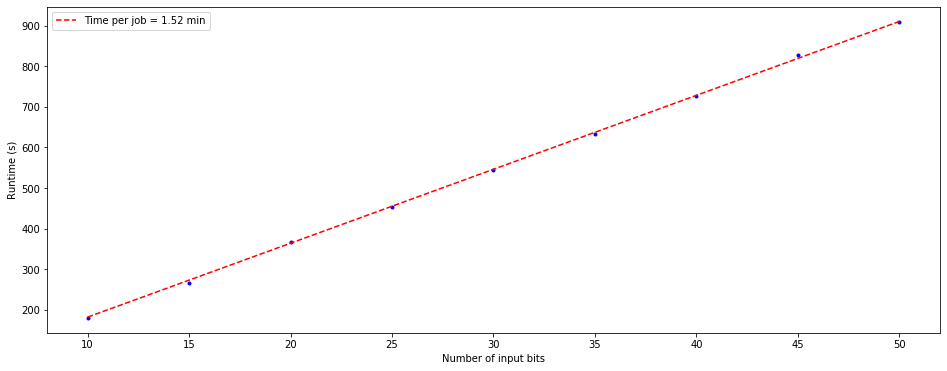

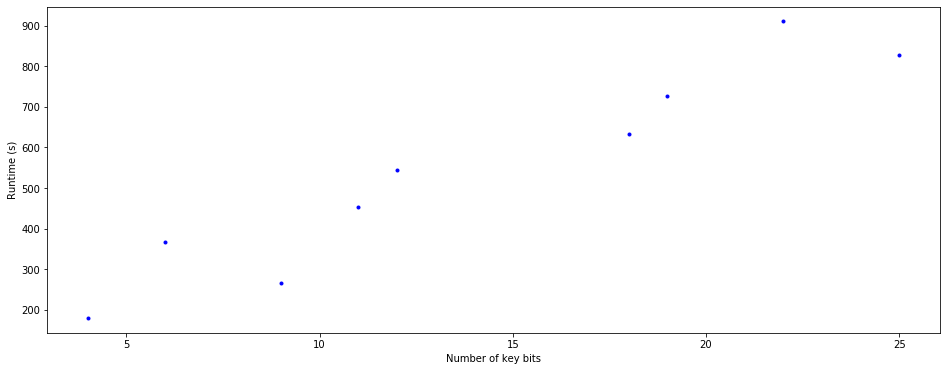

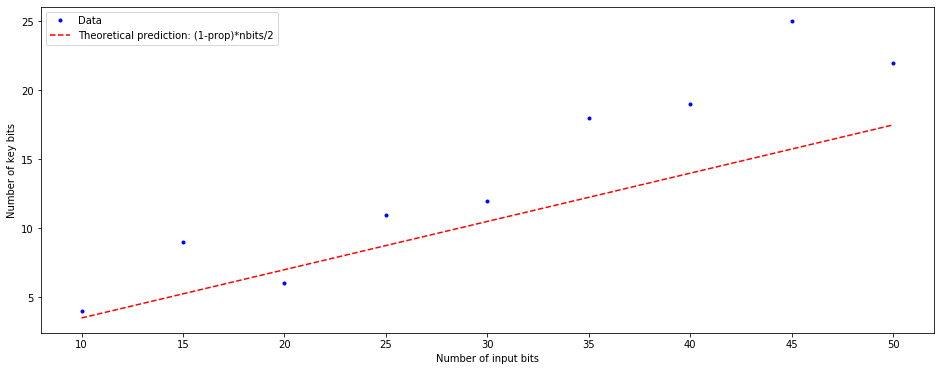

In [48]:
def lin_func(x,a):
    return a*x

from scipy.optimize import curve_fit

a, var_a = curve_fit(lin_func, nbits, dt, p0=(20))
plt.figure(figsize=(16,6))
plt.plot(nbits, dt, '.', c='b')
plt.plot(nbits, lin_func(nbits, a), ls='--', c='r', label='Time per job = '+str(round(a[0]*n_qubits/60,2)) + ' min')
plt.xlabel('Number of input bits')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.plot(n,dt, '.', c='b')
plt.xlabel('Number of key bits')
plt.ylabel('Runtime (s)')
plt.show()

plt.figure(figsize=(16,6))
plt.plot(nbits, n, '.', c='b', label='Data')
plt.plot(nbits, (1-prop)*nbits/2, ls='--', c='r', label='Theoretical prediction: (1-prop)*nbits/2')
plt.xlabel('Number of input bits')
plt.ylabel('Number of key bits')
plt.legend()
plt.show()